In [2]:
%pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 556.8 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 32.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 34.6 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 38.3 MB/s eta 0:00:00:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_6274/811229774.py:16: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date_time'] = pd.to_datetime(df['date_time'])


Root Mean Squared Error: 0.20030612546799462
R-squared Score: 0.7946432836565714
Model saved. You can load it later using joblib.load()
Predicted Magnitude: 6.5


/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


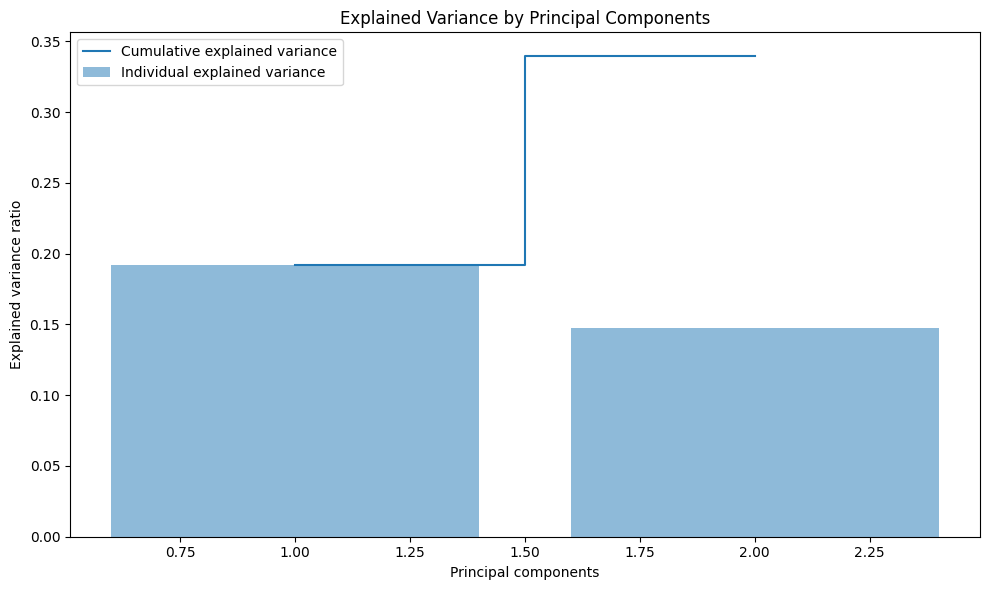

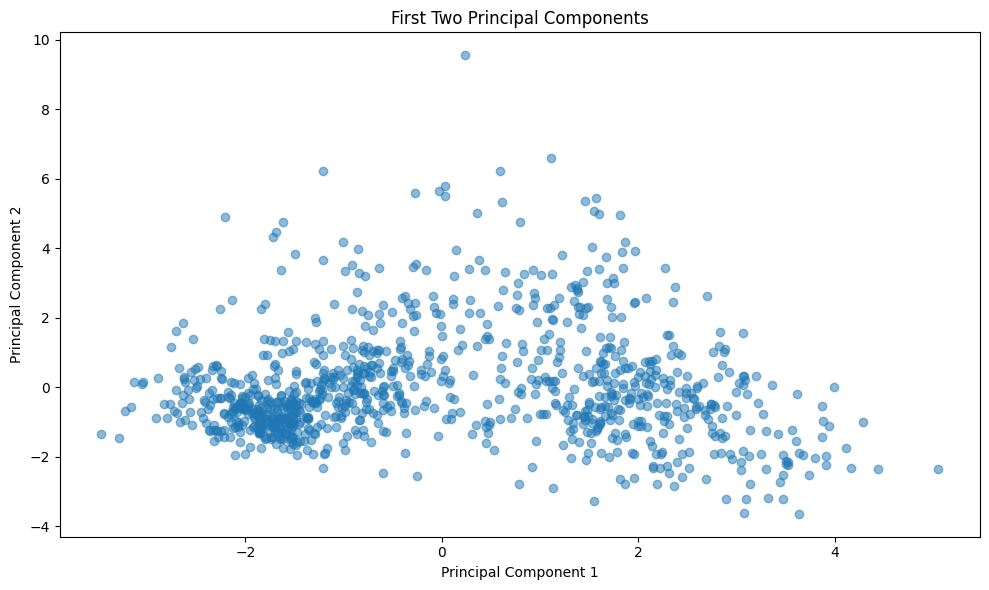

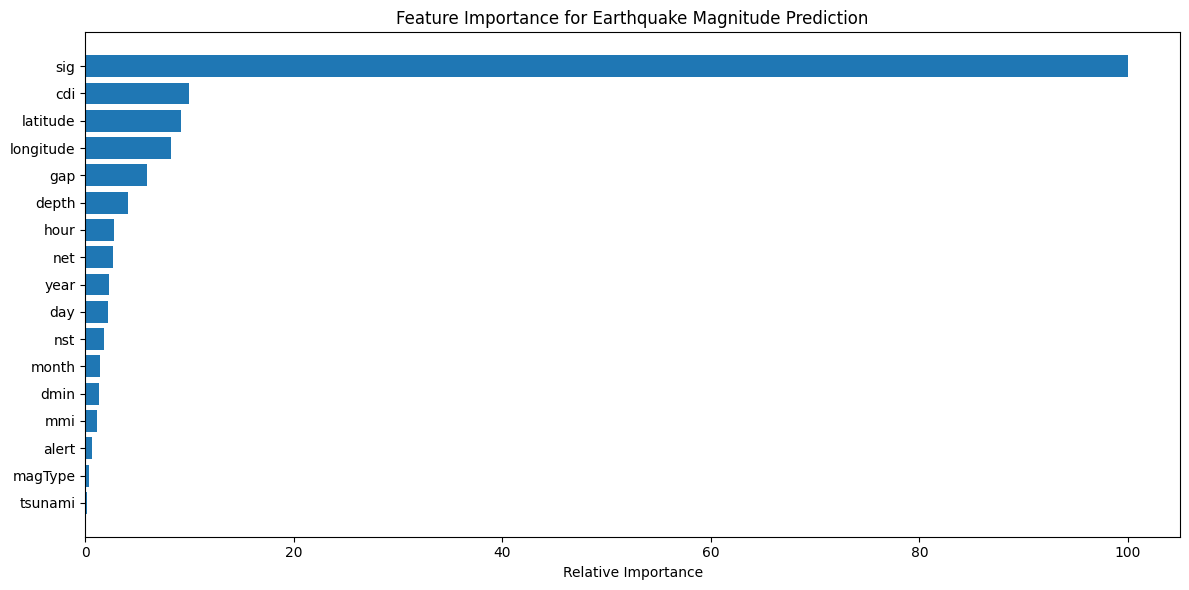

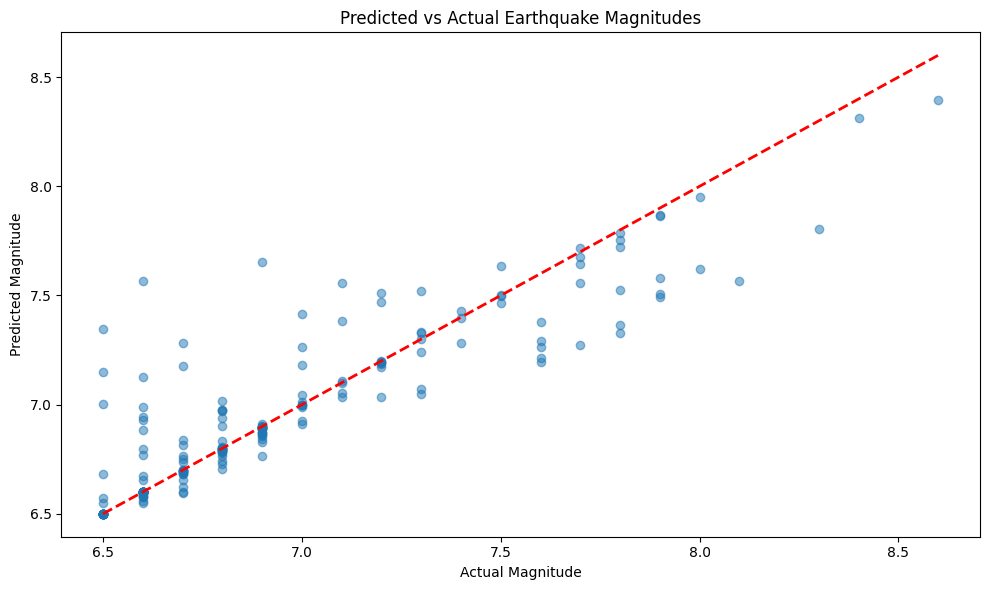

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import cartopy.crs as ccrs
import cartopy.feature as cfeature

df = pd.read_csv('/workspaces/Earthquake-Magnitude-Forecasting-and-Spatial-Analysis/earthquake_1995-2023.csv')

df['date_time'] = pd.to_datetime(df['date_time'])
df['year'] = df['date_time'].dt.year
df['month'] = df['date_time'].dt.month
df['day'] = df['date_time'].dt.day
df['hour'] = df['date_time'].dt.hour

# Encoding categorical features
le = LabelEncoder()
categorical_columns = ['alert', 'net', 'magType', 'location', 'continent', 'country']
for col in categorical_columns:
    df[col] = le.fit_transform(df[col].astype(str))

# Features and target variable
features = ['cdi', 'mmi', 'alert', 'tsunami', 'sig', 'net', 'nst', 'dmin', 'gap', 'magType', 
            'depth', 'latitude', 'longitude', 'year', 'month', 'day', 'hour']
X = df[features]
y = df['magnitude']

# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid', label='Cumulative explained variance')
plt.xlabel('Principal components')
plt.ylabel('Explained variance ratio')
plt.legend(loc='best')
plt.title('Explained Variance by Principal Components')
plt.tight_layout()
plt.savefig('explained_variance.png')

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('First Two Principal Components')
plt.tight_layout()
plt.savefig('principal_components.png')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared Score: {r2}")

feature_importance = model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance for Earthquake Magnitude Prediction')
plt.tight_layout()
plt.savefig('feature_importance.png')

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Magnitude')
plt.ylabel('Predicted Magnitude')
plt.title('Predicted vs Actual Earthquake Magnitudes')
plt.tight_layout()
plt.savefig('predicted_vs_actual.png')

def predict_magnitude(new_data):
    new_data_scaled = scaler.transform(new_data)
    return model.predict(new_data_scaled)

joblib.dump(model, 'earthquake_magnitude_model.joblib')
print("Model saved. You can load it later using joblib.load()")

#example
new_data = pd.DataFrame({
    'cdi': [3.5],
    'mmi': [2.3],
    'alert': [1],
    'tsunami': [0],
    'sig': [300],
    'net': [1],
    'nst': [15],
    'dmin': [0.02],
    'gap': [45],
    'magType': [1],
    'depth': [10.0],
    'latitude': [34.05],
    'longitude': [-118.25],
    'year': [2024],
    'month': [7],
    'day': [29],
    'hour': [12]
})

# Predict magnitude for the new data
predicted_magnitude = predict_magnitude(new_data)
print(f"Predicted Magnitude: {predicted_magnitude[0]}")

/tmp/ipykernel_6274/3140308242.py:4: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date_time'] = pd.to_datetime(df['date_time'])


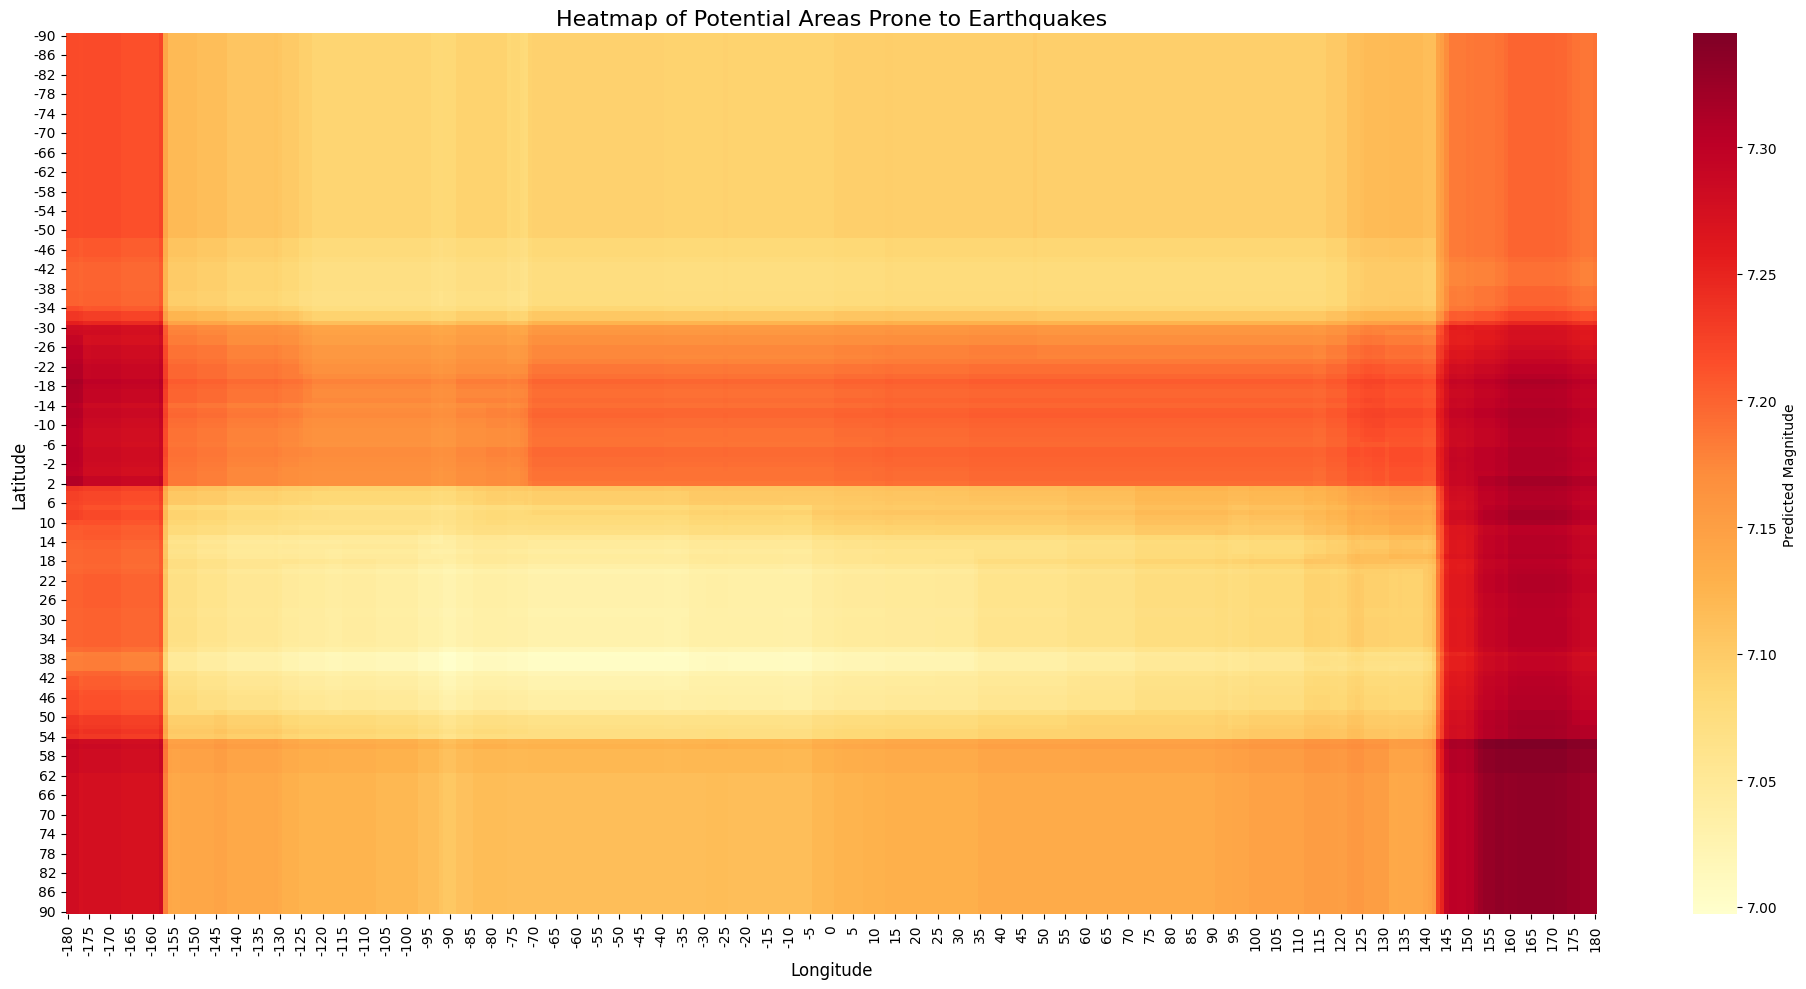

Heatmap saved as 'earthquake_prone_areas_heatmap.png'


/usr/local/python/3.10.13/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/python/3.10.13/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/python/3.10.13/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/python/3.10.13/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


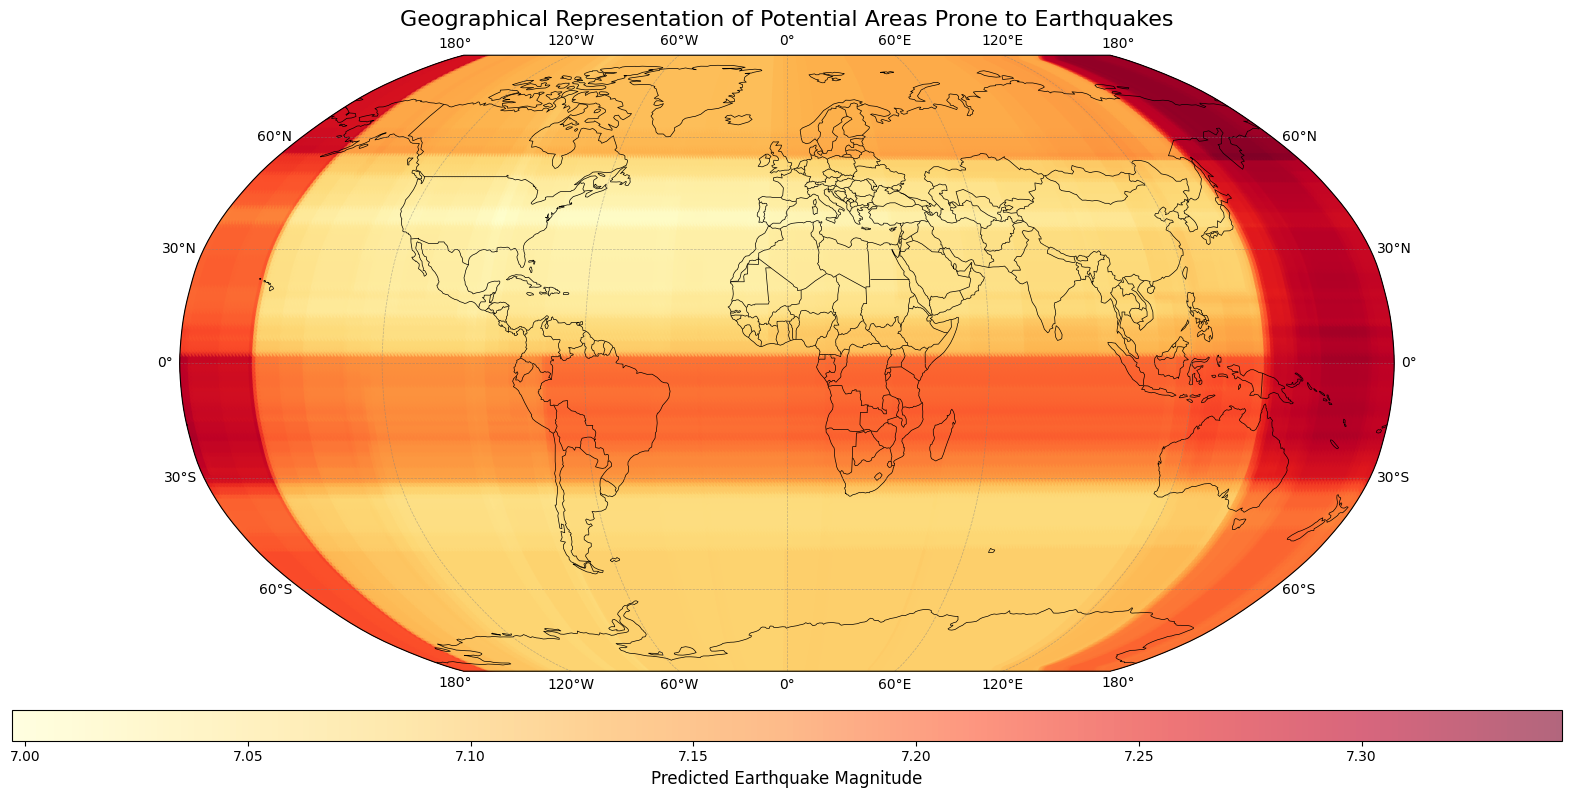

Geographical representation saved as 'earthquake_prone_areas_map_geographical_representation.png'


In [4]:
model = joblib.load('earthquake_magnitude_model.joblib')

df = pd.read_csv('/workspaces/Earthquake-Magnitude-Forecasting-and-Spatial-Analysis/earthquake_1995-2023.csv')
df['date_time'] = pd.to_datetime(df['date_time'])

le = LabelEncoder()
categorical_columns = ['alert', 'net', 'magType', 'location', 'continent', 'country']
for col in categorical_columns:
    df[col] = le.fit_transform(df[col].astype(str))

lat_range = np.arange(-90, 91, 1)
lon_range = np.arange(-180, 181, 1)
lat_lon_grid = np.array(np.meshgrid(lon_range, lat_range)).T.reshape(-1, 2)

grid_df = pd.DataFrame(lat_lon_grid, columns=['longitude', 'latitude'])
grid_df['cdi'] = df['cdi'].mean()
grid_df['mmi'] = df['mmi'].mean()
grid_df['alert'] = df['alert'].mode()[0]
grid_df['tsunami'] = df['tsunami'].mode()[0]
grid_df['sig'] = df['sig'].mean()
grid_df['net'] = df['net'].mode()[0]
grid_df['nst'] = df['nst'].mean()
grid_df['dmin'] = df['dmin'].mean()
grid_df['gap'] = df['gap'].mean()
grid_df['magType'] = df['magType'].mode()[0]
grid_df['depth'] = df['depth'].mean()
grid_df['year'] = df['date_time'].dt.year.max()  # Use the most recent year
grid_df['month'] = df['date_time'].dt.month.mode()[0]
grid_df['day'] = df['date_time'].dt.day.mode()[0]
grid_df['hour'] = df['date_time'].dt.hour.mode()[0]

features = ['cdi', 'mmi', 'alert', 'tsunami', 'sig', 'net', 'nst', 'dmin', 'gap', 'magType', 
            'depth', 'latitude', 'longitude', 'year', 'month', 'day', 'hour']

grid_df['predicted_magnitude'] = model.predict(grid_df[features])

grid_df = grid_df[grid_df['predicted_magnitude'] >= 4]

# Heatmap Visualization
heatmap_data = grid_df.pivot(index='latitude', columns='longitude', values='predicted_magnitude')

plt.figure(figsize=(20, 10))
sns.heatmap(heatmap_data, cmap='YlOrRd', cbar_kws={'label': 'Predicted Magnitude'})
plt.title('Heatmap of Potential Areas Prone to Earthquakes', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.tight_layout()
plt.savefig('earthquake_prone_areas_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Heatmap saved as 'earthquake_prone_areas_heatmap.png'")

# Geographical Representation Visualization
plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()

ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

scatter = ax.scatter(grid_df['longitude'], grid_df['latitude'], 
                     c=grid_df['predicted_magnitude'], 
                     cmap='YlOrRd', s=grid_df['predicted_magnitude']**2, 
                     alpha=0.6, transform=ccrs.PlateCarree())

cbar = plt.colorbar(scatter, orientation='horizontal', pad=0.05, aspect=50)
cbar.set_label('Predicted Earthquake Magnitude', fontsize=12)

plt.title('Geographical Representation of Potential Areas Prone to Earthquakes', fontsize=16)


ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

plt.savefig('earthquake_prone_areas_map_geographical_representation.png', dpi=300, bbox_inches='tight')
plt.show()

print("Geographical representation saved as 'earthquake_prone_areas_map_geographical_representation.png'")